In [39]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = ""  
db_port = "" 
db_name = ""
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [43]:
ace = '08|037|025|000|000' #selezioniamo ace
nome_ace = 'Dozza'

In [57]:
query= (""" SELECT 
  date,
  SUM(ingressi) AS ingressi,
  SUM(uscite) AS uscite 
FROM ( 
  SELECT
   DATE(datefrom) AS date,
    datavalue AS ingressi,
    0 AS uscite
  FROM movements
  WHERE toid LIKE '""" + ace + """'

  UNION ALL

  SELECT
    DATE(dateto) AS date,
    0 AS ingressi,
    datavalue AS uscite
  FROM movements
   WHERE layerid LIKE '""" + ace + """'
) AS movimenti
GROUP BY date
ORDER BY date; 
""")

try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df_flusso = pd.concat(chunks, ignore_index=True)  
    print(df_flusso)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date  ingressi  uscite
0   2019-08-01     10241    9463
1   2019-08-02      9752    9228
2   2019-08-03      9188    9601
3   2019-08-04      7757    7323
4   2019-08-05      8431    8785
..         ...       ...     ...
57  2019-09-27      9880   10284
58  2019-09-28     10000   10521
59  2019-09-29      9900   10329
60  2019-09-30     10096   10210
61  2019-10-01         0      36

[62 rows x 3 columns]


In [58]:
df_flusso = df_flusso.iloc[:-1]

In [61]:
query= (""" SELECT date, H, sum(P) AS P FROM presence WHERE ace = '""" + ace + """' GROUP BY date, H;""")

try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df_presence = pd.concat(chunks, ignore_index=True)
        df_presence.sort_values('date', inplace=True)
        df_presence.reset_index(drop=True, inplace=True)
    print(df_presence)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

            date         h     p
0     2019-08-01  14:45:00  2613
1     2019-08-01  07:15:00  2658
2     2019-08-01  23:30:00  2804
3     2019-08-01  22:30:00  2831
4     2019-08-01  03:45:00  2779
...          ...       ...   ...
5831  2019-09-30  19:30:00  2997
5832  2019-09-30  10:30:00  2526
5833  2019-09-30  08:00:00  2748
5834  2019-09-30  00:15:00  2901
5835  2019-09-30  02:15:00  2877

[5836 rows x 3 columns]


In [63]:
# Converte 'h' in datetime.time mantenendo minuti
df_presence['h'] = pd.to_datetime(df_presence['h'], format='%H:%M:%S').dt.time

# Ordina e resetta indice
df_presence.sort_values(['date', 'h'], inplace=True)
df_presence.reset_index(drop=True, inplace=True)

df_presence

,date,h,p
0,2019-08-01,00:00:00,2783
1,2019-08-01,00:15:00,2790
2,2019-08-01,00:30:00,2782
3,2019-08-01,00:45:00,2781
4,2019-08-01,01:00:00,2786
...,...,...,...
5831,2019-09-30,22:45:00,2999
5832,2019-09-30,23:00:00,2978
5833,2019-09-30,23:15:00,2961
5834,2019-09-30,23:30:00,2958


In [67]:
# Assicurati che le date siano in formato datetime
df_flusso['date'] = pd.to_datetime(df_flusso['date'])
df_presence['date'] = pd.to_datetime(df_presence['date'])

# Estrai solo la parte di giorno
df_flusso['day'] = df_flusso['date'].dt.date
df_presence['day'] = df_presence['date'].dt.date

# Aggrega df_presence per giorno (min e max delle presenze)
presence_daily = df_presence.groupby('day')['p'].agg(min_presence='min', max_presence='max').reset_index()

# Calcola media giornaliera di ingressi + uscite
df_flusso['mean'] = (df_flusso['ingressi'] + df_flusso['uscite']) / 2
flusso_daily = df_flusso.groupby('day')['mean'].mean().reset_index()

# Unisci i due risultati
df_result = pd.merge(presence_daily, flusso_daily, on='day')

# Visualizza risultato
print(df_result.head())


          day  min_presence  max_presence    mean
0  2019-08-01          2446          2868  9852.0
1  2019-08-02          2468          2935  9490.0
2  2019-08-03          2496          2833  9394.5
3  2019-08-04          2350          2620  7540.0
4  2019-08-05          2373          2616  8608.0


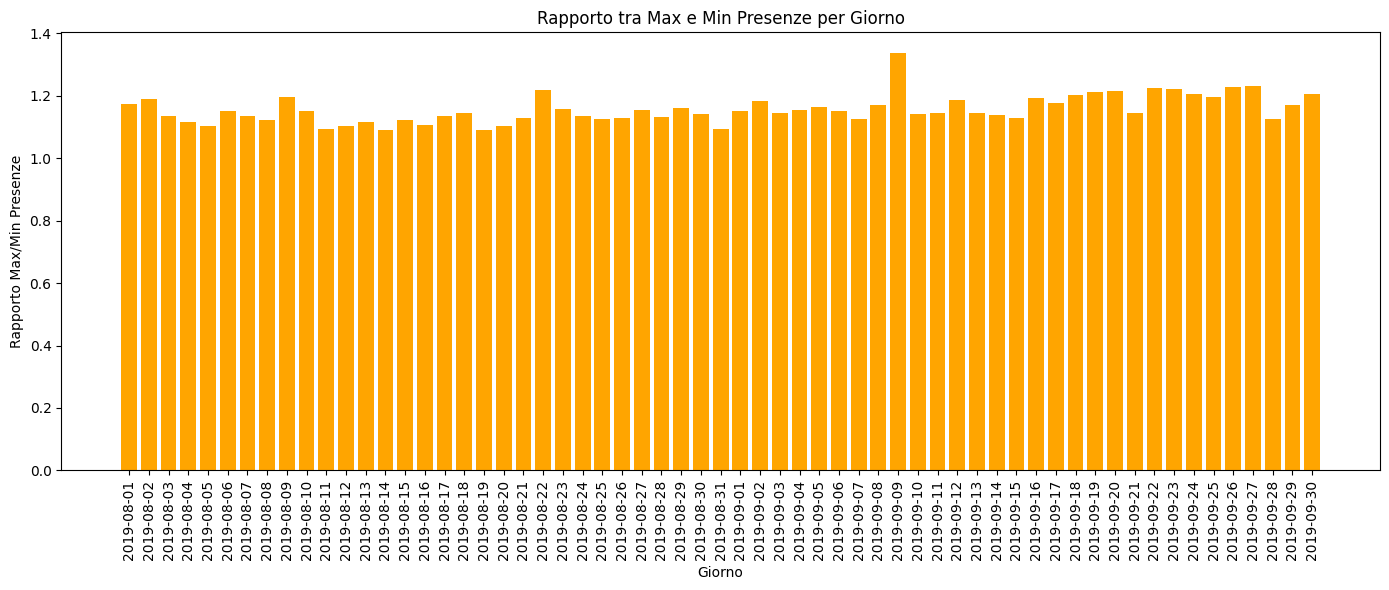

In [34]:
# Calcolo del rapporto
df_result['presence_ratio'] = df_result['max_presence'] / df_result['min_presence']

# Creazione del grafico a barre
plt.figure(figsize=(14, 6))
plt.bar(df_result['day'].astype(str), df_result['presence_ratio'], color='orange')
plt.xticks(rotation=90)
plt.xlabel('Giorno')
plt.ylabel('Rapporto Max/Min Presenze')
plt.title('Rapporto tra Max e Min Presenze per Giorno')
plt.tight_layout()
plt.show()

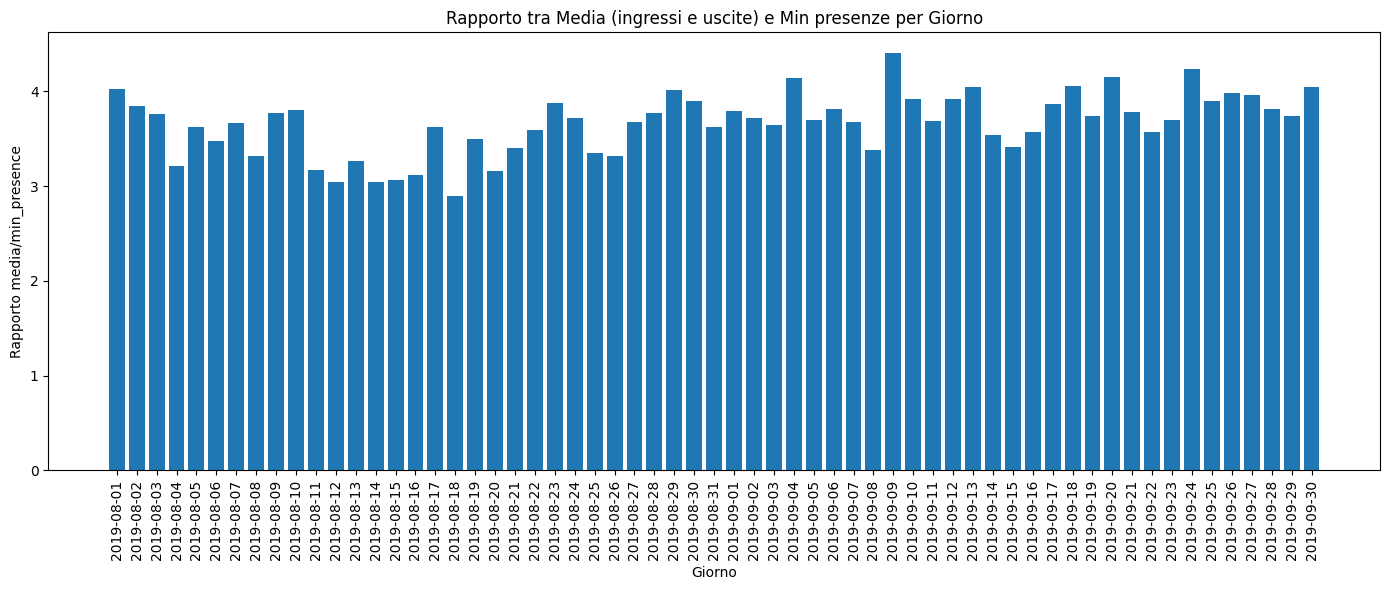

In [69]:
# Calcolo del rapporto
df_result['flottante'] = df_result['mean'] / df_result['min_presence']

# Creazione del grafico a barre
plt.figure(figsize=(14, 6))
plt.bar(df_result['day'].astype(str), df_result['flottante'])
plt.xticks(rotation=90)
plt.xlabel('Giorno')
plt.ylabel('Rapporto media/min_presence')
plt.title('Rapporto tra Media (ingressi e uscite) e Min presenze per Giorno')
plt.tight_layout()
plt.show()